## Env

In [4]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
api_key_groq=os.getenv("GROQ_API_KEY")

## LLM

In [5]:
from langchain_groq import ChatGroq 
llm = ChatGroq(model_name="llama-3.1-8b-instant", api_key=api_key_groq)
llm 

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000002824BD5B740>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002824C218140>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

## Tool 

In [6]:
def add(a,b): 
    """
    Add two numbers together
    """
    return a+b

In [7]:
def sub(a,b): 
    """
    Subtract two numbers
    """
    return a-b




In [8]:
def mul(a,b): 
    """
    Multiply two numbers
    """
    return a*b




## Tool with LLM 

In [11]:
tool = [add,sub,mul]

In [12]:
llm_with_tools = llm.bind_tools(tool)

## Messages

In [9]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage 
from typing import Annotated 
from langgraph.graph.message import add_messages
class State(TypedDict): 
    messages:Annotated[list[AnyMessage],add_messages]

## LLM with Tools 

In [13]:
def tool_fun(state:State): 
    llm_with_tools_local = llm.bind_tools(tool)
    return {"messages":[llm_with_tools_local.invoke(state["messages"])]}

## Graph 

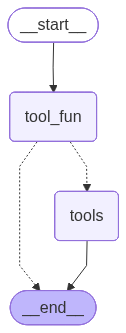

In [15]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode 
from langgraph.prebuilt import tools_condition
builder = StateGraph(State)
builder.add_node("tool_fun",tool_fun)
builder.add_node("tools",ToolNode(tool))
builder.add_edge(START,"tool_fun")
builder.add_conditional_edges("tool_fun",
tools_condition)
builder.add_edge("tools",END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
from langchain_core.messages import AIMessage, HumanMessage
messages=graph.invoke({"messages":HumanMessage(content="subtract 10 and 20")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

subtract 10 and 20
================================== Ai Message ==================================
Tool Calls:
  sub (a7rvkt3wv)
 Call ID: a7rvkt3wv
  Args:
    a: 10
    b: 20
================================= Tool Message =================================
Name: sub

-10


## Muitipe Nodes 

## LLMs

In [19]:
from langchain_groq import ChatGroq 
llm = ChatGroq(model_name="llama-3.1-8b-instant", api_key=api_key_groq)
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000002824D8BA9C0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002824D8C2990>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

## Tools 

In [ ]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """
    Add two numbers together
    """
    return a+b

@tool
def sub(a: int, b: int) -> int:
    """
    Subtract two numbers
    """
    return a-b

@tool
def mul(a: int, b: int) -> int:
    """
    Multiply two numbers
    """
    return a*b




In [ ]:
tool1=[add]
tool2=[sub]
tool3=[mul]
all_tools = tool1 + tool2 + tool3  # Combine all tools

## LLM with Tools 

In [ ]:
# Bind all tools together to the LLM
llm_with_tools = llm.bind_tools(all_tools)


## Message 

In [28]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage 
from langgraph.graph.message import add_messages
from typing import Annotated
class State(TypedDict): 
    messages:Annotated[list[AnyMessage],add_messages]

## Make the function for each tools 

In [ ]:
# Function that uses LLM with all tools to generate response
def tool_fun(state: State): 
    # Bind ALL tools together so LLM knows about all of them
    llm_with_tools_local = llm.bind_tools(all_tools)
    return {"messages": [llm_with_tools_local.invoke(state["messages"])]}

## Graph 

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode 
from langchain_core.messages import AIMessage

# Custom routing function that routes to specific tool nodes based on tool name
def route_tools(state: State):
    """
    Route to specific tool node based on which tool is called.
    If no tools are called, end the conversation.
    """
    last_message = state["messages"][-1]
    
    # If no tool calls, go to END
    if not isinstance(last_message, AIMessage) or not last_message.tool_calls:
        return END
    
    # Get the tool names that were called
    tool_calls = last_message.tool_calls
    tool_names = {call["name"] for call in tool_calls}
    
    # Route to the appropriate tool node based on which tool was called
    # Priority order: add -> sub -> mul
    # If multiple tools are called, route to the first matching one
    if "add" in tool_names:
        return "tools"
    elif "sub" in tool_names:
        return "tools2"
    elif "mul" in tool_names:
        return "tools3"
    else:
        return END

# Build the graph
builder = StateGraph(State)

# Add nodes
builder.add_node("tool_fun", tool_fun)
builder.add_node("tools", ToolNode(tool1))      # Handles 'add'
builder.add_node("tools2", ToolNode(tool2))     # Handles 'sub'
builder.add_node("tools3", ToolNode(tool3))     # Handles 'mul'

# Set entry point
builder.add_edge(START, "tool_fun")

# Add conditional routing from tool_fun to tool nodes
builder.add_conditional_edges("tool_fun", route_tools)

# After tool execution, loop back to tool_fun to continue conversation
builder.add_edge("tools", "tool_fun")
builder.add_edge("tools2", "tool_fun")
builder.add_edge("tools3", "tool_fun")

# Compile the graph
graph = builder.compile()

# Display the graph
display(Image(graph.get_graph().draw_mermaid_png()))




In [34]:
from langchain_core.messages import AIMessage, HumanMessage
messages=graph.invoke({"messages":HumanMessage(content="subtract 10 and 20")})
for m in messages['messages']:
    m.pretty_print()

BadRequestError: Error code: 400 - {'error': {'message': "tool call validation failed: attempted to call tool 'subtract' which was not in request.tools", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<function=subtract>{"a": 20, "b": 10}</function>'}}